# The effect of steel casing in AEM data

Figures 4, 5, 6 in Kang et al. (2020) are generated using this 

In [1]:
# core python packages
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.constants import mu_0, inch, foot
import ipywidgets
import properties
import time 
from scipy.interpolate import interp1d
from simpegEM1D.Waveforms import piecewise_pulse_fast

# SimPEG and discretize
import discretize
from discretize import utils
from SimPEG.EM import TDEM
from SimPEG import Utils, Maps
from SimPEG.Utils import Zero
from pymatsolver import Pardiso

# casing utilities
import casingSimulations as casingSim

%matplotlib inline

## Model Parameters

We will two classes of examples
- permeable wells, one example is run for each $\mu_r$ in `casing_mur`. The conductivity of this well is `sigma_permeable_casing`
- conductive wells ($\mu_r$=1), one example is run for each $\sigma$ value in `sigma_casing`

To add model runs to the simulation, just add to the list

In [2]:
# permeabilities to model
casing_mur = [100]
sigma_permeable_casing = 1.45*1e6

In [3]:
1./1.45*1e6

689655.1724137932

In [4]:
# background parameters
sigma_air = 1e-6
sigma_back = 1./340.
casing_t = 10e-3 # 10mm thick casing
casing_d = 300e-3 # 30cm diameter
casing_l = 200

def get_model(mur, sigc):
    model = casingSim.model.CasingInHalfspace(
        directory = simDir,
        sigma_air = sigma_air,
        sigma_casing = sigc,  # conductivity of the casing (S/m)
        sigma_back = sigma_back,  # conductivity of the background (S/m)
        sigma_inside = sigma_back,  # fluid inside the well has same conductivity as the background
        casing_d = casing_d-casing_t,  # 135mm is outer casing diameter
        casing_l = casing_l,
        casing_t = casing_t, 
        mur_casing = mur,
        src_a = np.r_[0., 0., 30.],
        src_b = np.r_[0., 0., 30.]
    )
 
    return model

## store the different models


In [5]:
simDir = "./"
model_names_permeable = ["casing_{}".format(mur) for mur in casing_mur]


model_dict_permeable = {
    key: get_model(mur, sigma_permeable_casing) for key, mur in zip(model_names_permeable, casing_mur)
}


model_names = model_names_permeable
model_dict = {}
model_dict.update(model_dict_permeable)

model_dict["baseline"] = model_dict[model_names[0]].copy()
model_dict["baseline"].sigma_casing = model_dict["baseline"].sigma_back
model_names = ["baseline"] + model_names
model_names

['baseline', 'casing_100']

## Create a mesh

In [6]:
# parameters defining the core region of the mesh
csx2 = 2.5  # cell size in the x-direction in the second uniform region of the mesh (where we measure data)
csz = 2.5  # cell size in the z-direction 
domainx2 = 100  # go out 500m from the well

# padding parameters
npadx, npadz = 19, 17  # number of padding cells
pfx2 = 1.4  # expansion factor for the padding to infinity in the x-direction
pfz = 1.4

# set up a mesh generator which will build a mesh based on the provided parameters
# and casing geometry
def get_mesh(mod):
    return casingSim.CasingMeshGenerator(
        directory=simDir,  # directory where we can save things
        modelParameters=mod,  # casing parameters
        npadx=npadx,  # number of padding cells in the x-direction
        npadz=npadz,  # number of padding cells in the z-direction
        domain_x=domainx2,  # extent of the second uniform region of the mesh 
#         hy=hy,   # cell spacings in the 
        csx1=mod.casing_t/4.,  # use at least 4 cells per across the thickness of the casing
        csx2=csx2,  # second core cell size
        csz=csz,  # cell size in the z-direction
        pfx2=pfx2,  # padding factor to "infinity"
        pfz=pfz  # padding factor to "infinity" for the z-direction
    )

In [7]:
mesh_generator = get_mesh(model_dict[model_names[0]])

In [8]:
mesh_generator.mesh.hx.sum()

5328.015964080293

In [9]:
mesh_generator.mesh.hx.min() * 1e3

2.5

In [10]:
mesh_generator.mesh.hz.sum()

5543.485677632954

In [11]:
# diffusion_distance(1e-2, 1./340.) * 2

## Physical Properties

In [12]:
# Assign physical properties on the mesh
physprops = {
    name: casingSim.model.PhysicalProperties(mesh_generator, mod) 
    for name, mod in model_dict.items()
}

In [13]:
from matplotlib.colors import LogNorm
import matplotlib
matplotlib.rcParams['font.size'] = 14

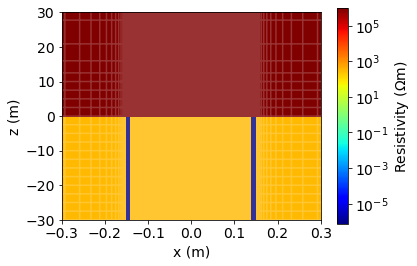

In [14]:
pp = physprops['casing_100']    
sigma = pp.sigma
fig, ax = plt.subplots()
out = mesh_generator.mesh.plotImage(
    1./sigma, grid=True, 
    gridOpts={'alpha':0.2, 'color':'w'}, 
    pcolorOpts={'norm':LogNorm(), 'cmap':'jet'}, 
    mirror=True, ax=ax
)
cb= plt.colorbar(out[0], ax=ax)
cb.set_label("Resistivity ($\Omega$m)")
ax.set_xlabel("x (m)")
ax.set_ylabel("z (m)")
ax.set_xlim(-0.3, 0.3)
ax.set_ylim(-30, 30)
ax.set_aspect(0.008)
plt.tight_layout()
fig.savefig("./figures/figure-4", dpi=200)

In [15]:
from simpegEM1D import diffusion_distance

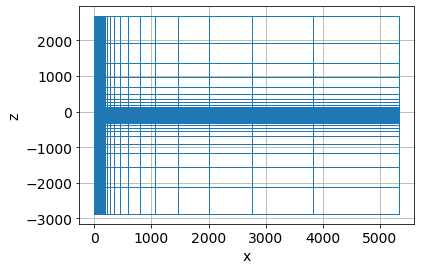

In [16]:
mesh_generator.mesh.plotGrid()

## Set up the time domain EM problem 

We run a time domain EM simulation with SkyTEM geometry

In [17]:
data_dir = "./data/"
waveform_hm = np.loadtxt(data_dir+"HM_butte_312.txt")
time_gates_hm = np.loadtxt(data_dir+"HM_butte_312_gates")[7:,:] * 1e-6
waveform_lm = np.loadtxt(data_dir+"LM_butte_312.txt")
time_gates_lm = np.loadtxt(data_dir+"LM_butte_312_gates")[8:,:] * 1e-6

time_input_currents_HM = waveform_hm[:,0]
input_currents_HM = waveform_hm[:,1]
time_input_currents_LM = waveform_lm[:,0]
input_currents_LM = waveform_lm[:,1]

time_LM = time_gates_lm[:,3] - waveform_lm[:,0].max()
time_HM = time_gates_hm[:,3] - waveform_hm[:,0].max()

base_frequency_HM = 30.
base_frequency_LM = 210.

radius = 13.25
source_area = np.pi * radius**2
pico = 1e12
def run_simulation(sigma, mu, z_src):        

    mesh = mesh_generator.mesh

    dts = np.diff(np.logspace(-6, -1, 50))
    timeSteps = []
    for dt in dts:
        timeSteps.append((dt, 1))

    prb = TDEM.Problem3D_e(
        mesh=mesh, timeSteps=timeSteps,
        Solver=Pardiso
    )

    x_rx = 0.
    z_offset = 0.
    rxloc = np.array([x_rx, 0., z_src+z_offset])
    srcloc = np.array([0., 0., z_src])
    times = np.logspace(np.log10(1e-5), np.log10(1e-2), 31)

    rx = TDEM.Rx.Point_dbdt(locs=np.array([x_rx, 0., z_src+z_offset]), times=times, orientation="z")
    src = TDEM.Src.CircularLoop(
            [rx], 
            loc=np.r_[0., 0., z_src], orientation="z", radius=13.25
    )
    area = np.pi * src.radius**2
    def bdf2(sigma):
        # Operators
        C = mesh.edgeCurl
        Mfmui = mesh.getFaceInnerProduct(1./mu_0)
        MeSigma = mesh.getEdgeInnerProduct(sigma)
        n_steps = prb.timeSteps.size
        Fz = mesh.getInterpolationMat(rx.locs, locType='Fz')
        eps = 1e-10
        def getA(dt, factor=1.):
            return C.T*Mfmui*C + factor/dt * MeSigma
        dt_0 = 0.
        data_test = np.zeros(prb.timeSteps.size)
        sol_n0 = np.zeros(mesh.nE)
        sol_n1 = np.zeros(mesh.nE)
        sol_n2 = np.zeros(mesh.nE)
        for ii in range(n_steps):
            dt = prb.timeSteps[ii]
            #Factor for BDF2
            factor=3/2.            
            if abs(dt_0-dt) > eps:
                if ii != 0:
                    Ainv.clean()                
#                 print (ii, factor)
                A = getA(dt, factor=factor)            
                Ainv = prb.Solver(A)
            if ii==0:        
                b0 = src.bInitial(prb)
                s_e = C.T*Mfmui*b0
                rhs = factor/dt*s_e
            elif ii==1:
                rhs = -factor/dt*(MeSigma*(-4/3.*sol_n1+1/3.*sol_n0) + 1./3.*s_e)
            else:
                rhs = -factor/dt*(MeSigma*(-4/3.*sol_n1+1/3.*sol_n0))
            sol_n2 = Ainv*rhs
            data_test[ii] = Fz*(-C*sol_n2)
            dt_0 = dt
            sol_n0 = sol_n1.copy()            
            sol_n1 = sol_n2.copy()    
        step_response = -data_test.copy() 

        step_func = interp1d(
            np.log10(prb.times[1:]), step_response
        )

        period_HM = 1./base_frequency_HM
        period_LM = 1./base_frequency_LM

        data_hm = piecewise_pulse_fast(
                            step_func, time_HM,
                            time_input_currents_HM, input_currents_HM,
                            period_HM, n_pulse=1
        )
        data_lm = piecewise_pulse_fast(
                            step_func, time_LM,
                            time_input_currents_LM, input_currents_LM,
                            period_LM, n_pulse=1
        )
        return np.r_[data_hm, data_lm] / area * pico
    return bdf2(sigma)

## Run the simulation

- for each permeability model we run the simulation for 2 conductivity models (casing = $10^6$S/m and $10^{-4}$S/m
- each simulation takes 15s-20s on my machine: the next cell takes ~ 4min to run

In [18]:
pp = physprops['baseline']    
sigma_base = pp.sigma
pp = physprops['casing_100']    
sigma = pp.sigma
mu = pp.mu
inds_half_space = sigma_base != sigma_air
inds_air = ~inds_half_space
inds_casing = sigma == sigma_permeable_casing

In [19]:
print (pp.mesh.hx.sum())
print (pp.mesh.hz.sum())

5328.015964080293
5543.485677632954


In [20]:
sigma_backgrounds = np.r_[1./1, 1./20, 1./100, 1./200, 1./340]

In [21]:
# start = timeit.timeit()
data_base = {}
data_casing = {}
for sigma_background in sigma_backgrounds:
    sigma_base = np.ones(pp.mesh.nC) * sigma_air
    sigma_base[inds_half_space] = sigma_background
    sigma = np.ones(pp.mesh.nC) * sigma_air
    sigma[inds_half_space] = sigma_background
    sigma[inds_casing] = sigma_permeable_casing
    
    for height in [20, 30, 40, 60, 80]:
        rho = 1/sigma_background
        name = str(int(rho)) + str(height)
        data_base[name] = run_simulation(sigma_base, mu_0, height)
        data_casing[name] = run_simulation(sigma, mu, height)
# end = timeit.timeit()
# print(("Elapsed time is %1.f")%(end - start))

In [22]:
rerr_max = []
for sigma_background in sigma_backgrounds:
    rerr_tmp = np.zeros(5)
    for ii, height in enumerate([20, 30, 40, 60, 80]):
        rho = 1/sigma_background
        name = str(int(rho)) + str(height)
        data_casing_tmp = data_casing[name]
        data_base_tmp = data_base[name]
        rerr_hm = abs(data_casing_tmp[:time_HM.size]-data_base_tmp[:time_HM.size]) / abs(data_base_tmp[:time_HM.size])
        rerr_lm = abs(data_casing_tmp[time_HM.size:]-data_base_tmp[time_HM.size:]) / abs(data_base_tmp[time_HM.size:])
#         rerr_tmp[ii] = np.r_[rerr_hm, rerr_lm].max()
        rerr_tmp[ii] = np.sqrt(((np.r_[rerr_hm, rerr_lm])**2).sum() / np.r_[rerr_hm, rerr_lm].size)
    rerr_max.append(rerr_tmp)

In [23]:
import matplotlib
matplotlib.rcParams['font.size'] = 14
fig_dir = "./figures/"

C:\Users\sgkan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  del sys.path[0]


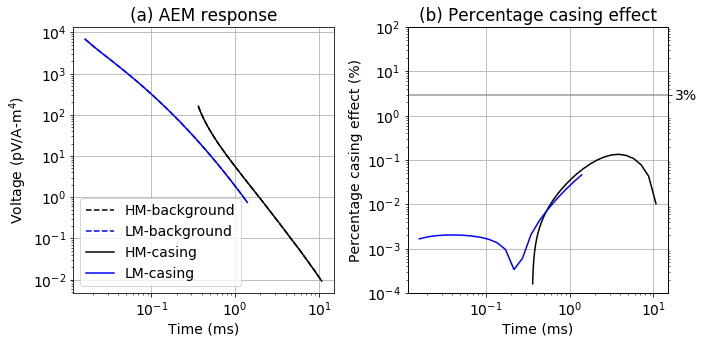

In [24]:
times = np.logspace(np.log10(1e-5), np.log10(1e-2), 31)
colors = ['k', 'b', 'g', 'r']
name='2040'
fig, axs = plt.subplots(1,2, figsize=(10, 5))
axs[0].loglog(time_gates_hm[:,3]*1e3, data_base[name][:time_HM.size], 'k--')
axs[0].loglog(time_gates_lm[:,3]*1e3, data_base[name][time_HM.size:], 'b--')
axs[0].loglog(time_gates_hm[:,3]*1e3, data_casing[name][:time_HM.size], 'k-')
axs[0].loglog(time_gates_lm[:,3]*1e3, data_casing[name][time_HM.size:], 'b-')
rerr_hm = abs(data_casing[name][:time_HM.size]-data_base[name][:time_HM.size]) / abs(data_base[name][:time_HM.size])
rerr_lm = abs(data_casing[name][time_HM.size:]-data_base[name][time_HM.size:]) / abs(data_base[name][time_HM.size:])
axs[1].loglog(time_gates_hm[:,3]*1e3, rerr_hm * 100, 'k-')
axs[1].loglog(time_gates_lm[:,3]*1e3, rerr_lm * 100, 'b-')
axs[1].set_ylim(0, 100)
axs[0].legend(('HM-background', 'LM-background', 'HM-casing', 'LM-casing'))
for ax in axs:
    ax.set_xlabel("Time (ms)")
    ax.grid(True)
axs[0].set_title('(a) AEM response')
axs[1].set_title('(b) Percentage casing effect')
axs[0].set_ylabel("Voltage (pV/A-m$^4$)")    
axs[1].set_ylabel("Percentage casing effect (%)") 
ax_1 = axs[1].twinx()
xlim = axs[1].get_xlim()
ax_1.loglog(xlim, (3,3), '-', color='grey', alpha=0.8)
axs[1].set_ylim((1e-4, 100))
ax_1.set_ylim((1e-4, 100))
axs[1].set_xlim(xlim)
ax_1.set_xlim(xlim)
ax_1.set_yticks([3])
ax_1.set_yticklabels(["3%"])

plt.tight_layout()
fig.savefig("./figures/figure-5", dpi=200)

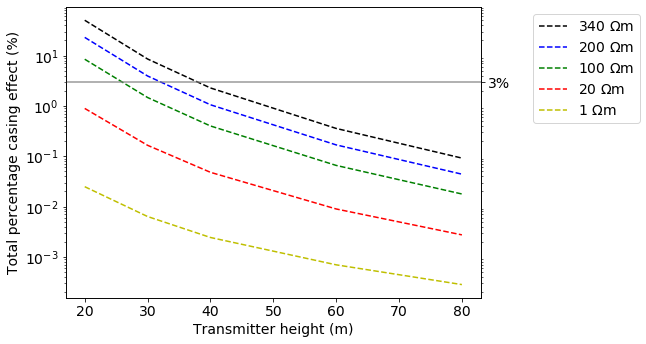

In [25]:
fig = plt.figure(figsize = (10,5))
ax = plt.gca()
ax_1 = ax.twinx()
markers = ['k--', 'b--', 'g--', 'r--', 'y--']
for ii, rerr in enumerate(rerr_max[::-1]):
    ax.plot([20, 30, 40, 60, 80], rerr*100, markers[ii], ms=10)
ax.set_xlabel("Transmitter height (m)")
ax.set_ylabel("Total percentage casing effect (%)")
ax.legend(("340 $\Omega$m", "200 $\Omega$m", "100 $\Omega$m", "20 $\Omega$m", "1 $\Omega$m",), bbox_to_anchor=(1.4,1))
ax.set_yscale('log')
ax_1.set_yscale('log')
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax_1.plot(xlim, (3,3), '-', color='grey', alpha=0.8)
ax.set_ylim(ylim)
ax_1.set_ylim(ylim)
ax.set_xlim(xlim)
ax_1.set_yticks([3])
ax_1.set_yticklabels(["3%"])
plt.tight_layout()
fig.savefig("./figures/figure-6", dpi=200)